In [129]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statistics 
import sklearn.metrics as metrics
import glob
import pickle

from functools   import reduce
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model          import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import SVC
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE

import seaborn as sns
%matplotlib inline

season_stats = pd.read_csv('nba-players-stats/Seasons_Stats.csv', index_col=0)

In [130]:
countable_columns = ['MP','2P','3P', 'FT','ORB','DRB','AST','STL','BLK','PTS']
independent_features = ['Player', 'MP', 'Pos', 'G', '2P', '2P%', '3P', '3P%', 'FT', 'FT%', 'USG%', 'ORB', 'DRB', 'AST', 'STL',  'BLK',  'PTS', 
                        'OWS', 'DWS', 'WS','OBPM', 'DBPM','BPM', 'VORP', 'isHoF']

## Current dataset only contains Hall of Famers until 2016 Inductee. Custom Inductees are added from 2012 to current
custom_inductee = ['Tracy McGrady', "George McGinnis", "Ray Allen", "Maurice Cheeks", "Grant Hill", "Jason Kidd",
                  'Steve Nash', 'Dino Radja', 'Vlade Divac', 'Bobby Jones', 'Sidney Moncrief', 'Jack Sikma','Tim Duncan',
                  'Kevin Garnett', 'Kobe Bryant', 'Shawn Marion', 'Chauncey Billups']

## Parameters which in app, receive from input. For now, set it as variable
position_for_model = 'C'


In [131]:

def hof_column_transformer(df):
    hof_container = df.copy()
    hof_container['Player'] = hof_container['Player'].str.replace("*", "_hof")
    hof_container = hof_container[hof_container['Player'].str.contains("_hof")]['Player'].str.replace("_hof", "*").unique()
    df['isHoF'] = ''
    df['isHoF'] = np.where(df['Player'].isin(hof_container), 1,0)
    df['Player'] = df['Player'].str.replace("*", "")
    return df

def div_by_game_and_rename_column(df):
    df[countable_columns]  = df[countable_columns].div(df['G'].values,axis=0)
    df.rename(columns={'MP':'MP/G','2P':'2P/G','3P':'3P/G','FT':'FT/G'
                                         ,'ORB':'ORB/G','DRB':'DRB/G','AST':'AST/G','STL':'STL/G'
                                         ,'BLK':'BLK/G','TOV':'TOV/G','PTS':'PTS/G'}, inplace=True)
    df.drop(['G'], axis=1, inplace=True)
    return df

def normalize_percentiles(df):
    df[['2P%', '3P%', 'FT%']] = df[['2P%', '3P%', 'FT%']] * 100
    df = df.round(2)
    return df
    
def filter_by_30_games(df):
    df.query('G >= 30')
    return df

def train_test_splitter(df):
    
    X = df
    y = df['isHoF']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=10, stratify =y)
    return  X_train,X_test,y_train,y_test

def generate_plot_df(X_train, y_train):
    
    df_plot = pd.DataFrame(data=X_train[1:-3], columns=X_train.columns[1:-3])
    df_plot['isHoF'] = y_train
    df_plot_hof  = df_plot[df_plot['isHoF'] == 1]
    df_plot_nhof  = df_plot[df_plot['isHoF'] == 0]
    return df_plot, df_plot_hof, df_plot_nhof

def generate_plt(plot_1, plot_2, plot_1_label, plot_2_label):
    plt.figure(figsize=(15, 15))
    for i, feature in enumerate(plot_1.columns[1:-1]):
        plt.subplot(5, 5, i+1)
        sns.distplot(plot_1[feature], bins=10, color="#5d80ff",
                      kde_kws={"label": plot_1_label},
                      hist_kws={"linewidth": 1,
                                "alpha": 0.5,"color": "#5d80ff"})
        sns.distplot(plot_2[feature], bins=10, color="#ffcc5d",
                      kde_kws={"label": plot_2_label},
                      hist_kws={"linewidth": 1,
                                "alpha": 0.5,"color": "#ffcc5d"})
        plt.xlabel(feature)
        plt.ylabel('Probability Density')
        plt.grid(True)
        plt.tight_layout()

def drop_player_name_and_label(X):
    X = X.drop(['Player', 'isHoF'],axis=1)
    return X

def standard_scale(X_train, X_test):
    X_scaler = StandardScaler(with_mean=True, with_std=True) 
    X_train_scaled = X_scaler.fit_transform(X_train) 
    X_test_scaled  = X_scaler.transform(X_test)
    return X_scaler, X_train_scaled, X_test_scaled

def custom_inductee_update(df):
    df[df['Player'].isin(custom_inductee)]
    df.loc[df.Player.isin(custom_inductee), 'isHoF'] = 1
    return df

def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 0.25)
    upper_limit = s.mean() + (s.std() * 3.5)
    return ~s.between(lower_limit, upper_limit)

def low_max_detection(df):
    q_low = df["MP/G"].quantile(0.15)
    q_hi  = df["MP/G"].quantile(0.75)
    df = df[(df["MP/G"] < q_hi) & (df["MP/G"] > q_low)]
    return df

def estimator_dict(name, estimator):
    model = {'name':name, 'estimator':estimator}
    return model

def filter_by_position(df, pos):
    df = df[df['Pos'] == pos]
    return df

def update_dominant_position(df):
    for player in list(set(df['Player'].tolist())):
        dominant_position = df.query("Player == @player")['Pos'].describe()['top']
        player_name = list(df['Player'].tolist())[0]
        df['Pos'] = np.where(df['Player'] == player_name, dominant_position, df['Pos'])  
    return df

def find_optimum_features(df):
    X = df.iloc[:,1:-1]
    y = df['isHoF']
    cv_k = int(df.shape[0]/(df.shape[0]*0.30))

    rfc = RandomForestClassifier(random_state=10)
    rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(cv_k), scoring='accuracy')
    rfecv.fit(X, y)
    support = rfecv.support_

    print("Optimal number of features : %d" % rfecv.n_features_)

    support = np.insert(support, 0, True, axis=0)
    support = np.append(support, True)
    optimized_features = df.columns[support]
    return optimized_features

<h4> Data cleaning for historical data and recent players </h4>

In [132]:
## Data Filter / Data Clean / Hall of Fame column

## Players past 1980 and minimum number of games > 30 are used for evaluation
season_stats_filtered = season_stats.copy()
season_stats_filtered = season_stats.query('Year >= 1980')
season_stats_filtered = season_stats.query('Year <= 2009')
season_stats_filtered = filter_by_30_games(season_stats_filtered)

## Removed columns with no predictive power
season_stats_filtered.drop(['GS','blanl','blank2','blank2','Age', 'Tm'], axis=1, inplace=True)

## All the null values are handled - these values are null because there is 0 sample for the percentiles - thus 0.
season_stats_filtered.fillna(0, inplace=True)
season_stats_filtered = hof_column_transformer(season_stats_filtered)
season_stats_filtered = custom_inductee_update(season_stats_filtered)

# display(season_stats_filtered.query('Player == "LeBron James"'))
# season_stats_filtered = update_dominant_position(season_stats_filtered)
# display(season_stats_filtered.query('Player == "LeBron James"'))
season_stats_filtered = season_stats_filtered[independent_features]

season_stats_filtered = div_by_game_and_rename_column(season_stats_filtered)
season_stats_filtered = season_stats_filtered[~season_stats_filtered.groupby('Player')['MP/G'].apply(is_outlier)].reset_index(drop=True)
# season_stats_filtered = low_max_detection(season_stats_filtered)
season_stats_filtered = filter_by_position(season_stats_filtered, position_for_model)
season_stats_filtered = season_stats_filtered.groupby('Player').mean().reset_index()
season_stats_filtered['isHoF'] = np.where(season_stats_filtered['isHoF'] == 0, 0, 1)
season_stats_filtered = normalize_percentiles(season_stats_filtered)


In [133]:
norm_tables = []
adv_tables = []
filtered_tables = []

for filepath in glob.iglob('recent-nba-players-stats/*.csv'):
    df = pd.read_csv(filepath, index_col=0)  
    df = filter_by_30_games(df)
    if '_adv' in filepath:
        df = df[['Player', 'Pos', 'USG%','OWS', 'DWS', 'WS','OBPM', 'DBPM','BPM', 'VORP']]
        df = update_dominant_position(df)
        df = filter_by_position(df, position_for_model)
        df.fillna(0, inplace=True)
        df = df.groupby('Player').mean()
        df = df.round(2).reset_index()
        adv_tables.append(df)       
    else:
        df = df[['Player', 'Pos', 'G', 'MP', '3P', '3P%', '2P','2P%','FT', 'FT%', 
                 'ORB', 'DRB',  'AST', 'STL', 'BLK', 'PTS']]
        df = update_dominant_position(df)
        
        df = filter_by_position(df, position_for_model)
        df.fillna(0, inplace=True)
        df = df.groupby('Player').mean()
        df = df.round(2).reset_index()
        norm_tables.append(df)      

for n_df, adv_df in zip(norm_tables, adv_tables):
    merged_df = pd.merge(n_df, adv_df, on="Player")
    merged_df = div_by_game_and_rename_column(merged_df)
    merged_df = merged_df.round(2)
    merged_df['Player'] = merged_df['Player'].str.split(r"\\|=", expand=True)
    
    merged_df = merged_df.reindex(columns=merged_df.columns)
    filtered_tables.append(merged_df)

joined_df = pd.concat([filtered_tables[0],filtered_tables[1],filtered_tables[2],
                       filtered_tables[3],filtered_tables[4]], axis=0)
joined_df = joined_df.groupby('Player').mean().round(2)
joined_df = joined_df[season_stats_filtered.columns[1:-1]]
joined_df = joined_df.reset_index()
joined_df['Player'] = joined_df['Player'].str.replace("*", "")

In [134]:
optimized_features = find_optimum_features(season_stats_filtered)
season_stats_filtered = season_stats_filtered[optimized_features]
joined_df = joined_df[optimized_features[:-1]]

Optimal number of features : 11


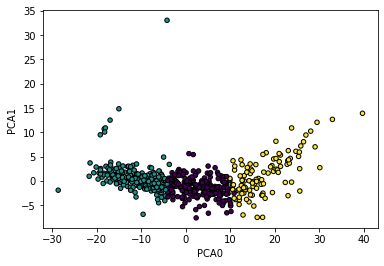

In [135]:
df_pca = season_stats_filtered.iloc[:,1:-1]
# 1. Instantiate
my_pca = PCA(n_components=3)
# 2. Fit (mathematical calculations are made at this step) 
my_pca.fit(df_pca)
# 3. Transform
X_PCA = my_pca.transform(df_pca)

a = pd.DataFrame()

a['PCA0'] = X_PCA[:, 0] 
a['PCA1'] = X_PCA[:, 1] 
a['PCA2'] = X_PCA[:, 2]

#Specify the model
k_means_model = KMeans(n_clusters = 3)
#Fit the model to the data
k_means_model.fit(a)

#Annotate the data points with the K-Means prediction
pred_labels = k_means_model.predict(a)
# OR equivalently, the labels are stored within labels_ 
pred_labels = k_means_model.labels_
#Plot the data:
plt.figure()
plt.scatter(a['PCA0'], a['PCA1'], c=pred_labels, s=20, edgecolor='k')
plt.xlabel('PCA0')
plt.ylabel('PCA1')
plt.show();

season_stats_filtered['type_of_player'] = pred_labels

encoded_df = pd.get_dummies(season_stats_filtered['type_of_player'])
season_stats_filtered = pd.concat([season_stats_filtered, encoded_df], axis=1)
season_stats_filtered = season_stats_filtered.drop(['type_of_player'],axis=1)
season_stats_filtered.rename(columns={'0':'player_type_0','1':'player_type_1','2':'player_type_2'}, inplace=True)

In [136]:
season_stats_filtered

,Player,MP/G,2P/G,FT/G,DRB/G,AST/G,PTS/G,OWS,DWS,WS,BPM,VORP,isHoF,0,1,2
0,Aaron Gray,12.77,1.45,0.61,2.43,0.82,3.50,0.50,0.80,1.30,-1.50,0.10,0,0,1,0
1,Aaron Williams,18.78,2.28,1.15,2.67,0.76,5.71,0.97,1.55,2.55,-1.40,0.22,0,1,0,0
2,Acie Earl,13.45,1.95,1.43,1.68,0.43,5.33,-0.45,0.55,0.10,-6.60,-0.82,0,0,1,0
3,Adam Keefe,25.59,2.86,2.02,3.24,1.11,7.75,4.80,1.70,6.50,2.30,2.20,0,1,0,0
4,Adonal Foyle,19.99,2.02,0.54,3.32,0.54,4.58,0.46,1.56,2.02,-0.68,0.50,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,Zaza Pachulia,24.40,3.05,2.96,3.85,1.17,9.07,2.20,1.68,3.88,-0.73,0.60,0,1,0,0
551,Zeljko Rebraca,15.88,2.66,1.15,2.14,0.45,6.47,0.74,0.80,1.54,-3.34,-0.04,0,0,1,0
552,Zelmo Beaty,35.88,6.94,4.62,0.00,1.58,18.51,5.62,2.83,8.43,0.00,0.00,1,0,0,1
553,Zendon Hamilton,8.85,0.82,1.65,1.76,0.22,3.29,0.33,0.23,0.63,-10.50,-0.10,0,0,1,0


<h4> Initial EDA </h4>

In [137]:
X_train,X_test,y_train,y_test = train_test_splitter(season_stats_filtered)

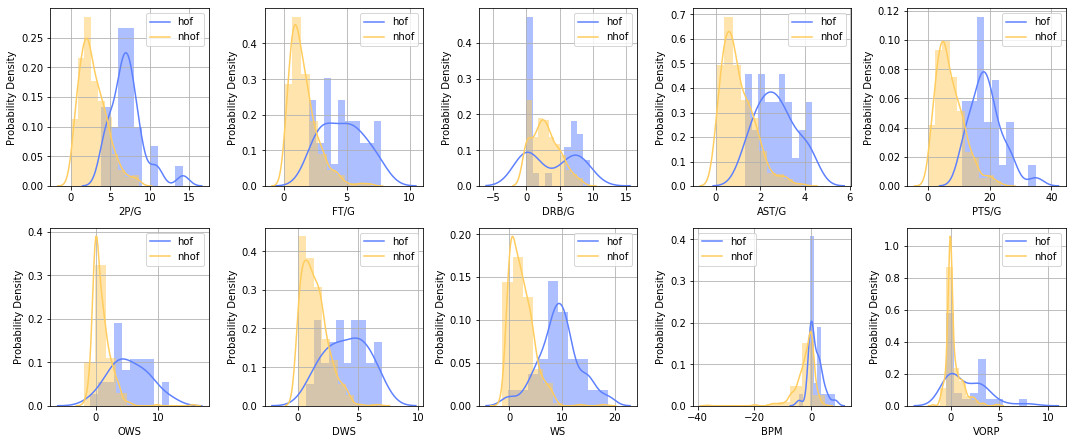

In [138]:
df_plot, df_plot_hof, df_plot_nhof = generate_plot_df(X_train, y_train)
generate_plt(df_plot_hof, df_plot_nhof, 'hof', 'nhof')

In [139]:
models = []

models.append(estimator_dict('K-Nearest Neighbours Classifier', KNeighborsClassifier(n_neighbors=5, weights='uniform')))
models.append(estimator_dict('Logistic Regression Classifier', LogisticRegression(C=0.1, random_state=10)))
models.append(estimator_dict('SVM Classifier', SVC(probability=True, random_state=10)))
models.append(estimator_dict('Stochastic Gradient Descent Classifier', SGDClassifier(loss="log", random_state=10)))
models.append(estimator_dict('Gaussian Naive Bayes Classifier', GaussianNB()))
models.append(estimator_dict('Decision Tree Classifier', DecisionTreeClassifier(max_depth=10, max_features='auto', random_state=10)))
models.append(estimator_dict('Random Forest Classifier', RandomForestClassifier(n_estimators=200, max_depth=None, max_features='auto', random_state=10)))
models.append(estimator_dict('Adaptive Boosted Decision Tree Classifier', AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=10)))
models.append(estimator_dict('Gradient Boosted Decision Tree Classifier', GradientBoostingClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=10)))

In [140]:
## TODO: ensemble model

<h4> Model Training , Model Evaluation, and Imbalanced Model Training by SMOTE </h4>

In [141]:
init_X_train = X_train.copy()
init_X_test = X_test.copy()
init_y_train = y_train.copy()
init_y_test = y_test.copy()

In [142]:
X_train = drop_player_name_and_label(X_train)
X_test = drop_player_name_and_label(X_test)

X_scaler, X_train_scaled, X_test_scaled = standard_scale(X_train, X_test)

smote = SMOTE(sampling_strategy='auto', k_neighbors=2)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

In [143]:
model_vals = []
df_summary_lists = []
     
with open("models.pckl", "wb") as f:
    for model_dict in models:

        name = model_dict['name']
        estimator = model_dict['estimator']

        print("doing estimation on...", model_dict['name'])

        model = estimator.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
#         y_pred = (estimator.predict_proba(X_test_scaled)[:,1] >= 0.85).astype(bool)
        pickle.dump(model, f)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        thresholds = np.arange(0.25, 0.75, 0.01)
        precisions = list()
        recalls = list()
        f1_list = list()
        roc_auc_list = list()
        
        ## Df: player, pred_proba,label, true_label

        for threshold in thresholds:
            y_proba = model.predict_proba(X_test_scaled)[:,1]
            y_threshold = np.where(y_proba > threshold, 1, 0)
            precision = precision_score(y_test, y_threshold)
            recall = recall_score(y_test, y_threshold)
            roc_auc = roc_auc_score(y_test, y_proba)
            f1 = f1_score(y_test, y_pred)
            acc_score = accuracy_score(y_pred, y_test)
            
            precisions.append(precision)
            recalls.append(recall)
            f1_list.append(f1)
            roc_auc_list.append(roc_auc)

        model_val = {"name": name, "precision_mean" : statistics.mean(precisions), 
                     "recall_mean" : statistics.mean(recalls),
                     "f1_mean":statistics.mean(f1_list),'accuracy_score':acc_score, 'TP': tp,
                     "TN": tn, "FP": fp, "FN": fn, 'roc_auc': statistics.mean(roc_auc_list).round(2)
                    }
        
        
        model_vals.append(model_val)
    
df_sum = pd.DataFrame.from_dict(model_vals)
df_summary_lists.append(df_sum)
# df_sum['f1_wa'] = (df_sum['f1_mean'] /  df_sum['f1_mean'].sum()).round(2)

display(df_sum)

doing estimation on... K-Nearest Neighbours Classifier
doing estimation on... Logistic Regression Classifier
doing estimation on... SVM Classifier
doing estimation on... Stochastic Gradient Descent Classifier
doing estimation on... Gaussian Naive Bayes Classifier
doing estimation on... Decision Tree Classifier
doing estimation on... Random Forest Classifier
doing estimation on... Adaptive Boosted Decision Tree Classifier
doing estimation on... Gradient Boosted Decision Tree Classifier


,name,precision_mean,recall_mean,f1_mean,accuracy_score,TP,TN,FP,FN,roc_auc
0,K-Nearest Neighbours Classifier,0.521765,0.900,0.666667,0.935252,9,121,8,1,0.97
1,Logistic Regression Classifier,0.440494,0.892,0.562500,0.899281,9,116,13,1,0.97
2,SVM Classifier,0.552499,0.816,0.666667,0.935252,9,121,8,1,0.96
3,Stochastic Gradient Descent Classifier,0.587714,0.310,0.285714,0.928058,2,127,2,8,0.95
4,Gaussian Naive Bayes Classifier,0.333333,0.900,0.486486,0.863309,9,111,18,1,0.96
5,Decision Tree Classifier,0.466667,0.700,0.560000,0.920863,7,121,8,3,0.82
6,Random Forest Classifier,0.550924,0.880,0.720000,0.949640,9,123,6,1,0.96
7,Adaptive Boosted Decision Tree Classifier,0.250666,0.632,0.666667,0.935252,9,121,8,1,0.96
8,Gradient Boosted Decision Tree Classifier,0.421053,0.800,0.551724,0.906475,8,118,11,2,0.95


<h4>Loading pre-trained model</h4>

In [144]:
loaded_models = []
with open("models.pckl", "rb") as f:
    while True:
        try:
            loaded_models.append(pickle.load(f))
        except EOFError:
            break

In [145]:
TP_list_agg = [] ## Hall of Famer
TN_list_agg = [] ## Non Hall of Famer
FP_list_agg = [] ## Non Hall of Famer being predicted as Hall of Famer
FN_list_agg = [] ## Hall of Famer being predicted as Non Hall of Famer

for model in loaded_models:
    
    TP_list = [] ## Hall of Famer
    TN_list = [] ## Non Hall of Famer
    FP_list = [] ## Non Hall of Famer being predicted as Hall of Famer
    FN_list = [] ## Hall of Famer being predicted as Non Hall of Famer
    current_player_list = []
    
    name = type(model).__name__
  
    y_prediction = model.predict(X_test_scaled)  
    y_test_np = y_test.to_numpy()
    
    print("==> Checking which players are Hall of Famer according to {} ...".format(name))  
    
    for i in range(len(X_test_scaled)):
        player_name = init_X_test.iloc[i]['Player']
        if ((y_test_np[i] == 0) and (y_prediction[i] == 0)):   # TN

            TN_list.append(player_name)
        elif ((y_test_np[i] == 0) and (y_prediction[i] == 1)): # FP
           
            FP_list.append(player_name)
        elif ((y_test_np[i] == 1) and (y_prediction[i] == 0)): # FN
            
            FN_list.append(player_name)
        else:                                                # TP
           
            TP_list.append(player_name)
    
    print("--> # of HoF predicted to be HoF = {:>3} (TP)".format(len(TP_list)))
    print("--> # of HoF predicted to be non-HoF = {:>3} (FN)".format(len(FN_list)))
    print("--> # of non-HoF predicted to be HoF = {:>3} (FP)".format(len(FP_list)))
    print("--> # of non-HoF predicted to be non-HoF = {:>3} (TN)".format(len(TN_list)))
    print("")
    print("--> # of HoF predicted to be HoF", TP_list)
    print(" ")
    print("--> # of HoF predicted to be non-HoF", FN_list)
    print(" ")
    print("--> # of non-HoF predicted to be HoF", FP_list)
    print(" ")

    TP_list_agg.append(TP_list)
    TN_list_agg.append(TN_list)
    FP_list_agg.append(FP_list)
    FN_list_agg.append(FN_list)


==> Checking which players are Hall of Famer according to KNeighborsClassifier ...
--> # of HoF predicted to be HoF =   9 (TP)
--> # of HoF predicted to be non-HoF =   1 (FN)
--> # of non-HoF predicted to be HoF =   8 (FP)
--> # of non-HoF predicted to be non-HoF = 121 (TN)

--> # of HoF predicted to be HoF ['Bob McAdoo', 'Bob Lanier', 'Kareem Abdul-Jabbar', 'Patrick Ewing', 'Bill Russell', 'Robert Parish', 'Clyde Lovellette', 'Yao Ming', 'Hakeem Olajuwon']
 
--> # of HoF predicted to be non-HoF ['Arnie Risen']
 
--> # of non-HoF predicted to be HoF ['Alvan Adams', 'Chris Bosh', 'Dwight Howard', 'Horace Grant', 'Sam Lacey', 'Dirk Nowitzki', 'David Lee', 'Brad Daugherty']
 
==> Checking which players are Hall of Famer according to LogisticRegression ...
--> # of HoF predicted to be HoF =   9 (TP)
--> # of HoF predicted to be non-HoF =   1 (FN)
--> # of non-HoF predicted to be HoF =  13 (FP)
--> # of non-HoF predicted to be non-HoF = 116 (TN)

--> # of HoF predicted to be HoF ['Bob McAdo

In [146]:
X_PCA = my_pca.transform(joined_df.iloc[:,1:])
a = pd.DataFrame()

a['PCA0'] = X_PCA[:, 0] 
a['PCA1'] = X_PCA[:, 1] 
a['PCA2'] = X_PCA[:, 2]

#Specify the model
k_means_model = KMeans(n_clusters = 3)
#Fit the model to the data
k_means_model.fit(a)

#Annotate the data points with the K-Means prediction
pred_labels = k_means_model.predict(a)
# OR equivalently, the labels are stored within labels_ 
pred_labels = k_means_model.labels_

joined_df['type_of_player'] = pred_labels

encoded_df = pd.get_dummies(joined_df['type_of_player'])
joined_df = pd.concat([joined_df, encoded_df], axis=1)
joined_df = joined_df.drop(['type_of_player'],axis=1)
joined_df.rename(columns={'0':'player_type_0','1':'player_type_1','2':'player_type_2'}, inplace=True)

X = joined_df.drop(['Player'],axis=1)
X_recent_scaled = X_scaler.transform(X)



In [147]:
agg_player_list = []

for model in loaded_models:
    player_list = []
    name = type(model).__name__

    y_prediction = model.predict(X_recent_scaled)  
    
    y_proba = model.predict_proba(X_recent_scaled)[:,1]
    for i in range(len(X_recent_scaled)):
        player_name = joined_df.iloc[i]['Player']
        player_proba = y_proba[i]
        if y_prediction[i] == 1:          
            if player_proba >= 0.6:
                player_name_and_proba_dict = {'Name':player_name, "Probability":player_proba}
                player_list.append(player_name_and_proba_dict)
            else:
                continue
        else:
            continue
    agg_player_list.append(player_list)

In [148]:
lst = [item for sublist in agg_player_list for item in sublist]
from collections import Counter

frequency = Counter(x['Name'] for x in lst)

main_df = pd.DataFrame(lst)
modified_df = main_df.groupby(['Name'], as_index=False).sum()
modified_df = pd.merge(modified_df, main_df.groupby(['Name']).size().to_frame(), on="Name")
modified_df.rename(columns={0: 'freq'}, inplace=True)
modified_df['proba_agg'] = modified_df['proba_agg'] = modified_df['Probability']/modified_df['freq']

top_10_recent_players = modified_df.query('freq > 1').sort_values(['freq', 'proba_agg'],ascending=False).round(2).head(10)
top_10_recent_players


,Name,Probability,freq,proba_agg
14,Marc Gasol,4.10,5,0.82
15,Pau Gasol,3.26,4,0.82
11,Dwight Howard,2.70,3,0.90
17,Tim Duncan,1.74,2,0.87
13,Joakim Noah,1.68,2,0.84


In [149]:
## Find all players from modified_df from joined_df
top_10_df = joined_df[joined_df['Player'].isin(top_10_recent_players['Name'])]
top_10_df['isHoF'] = 1
historic_hof_average = season_stats_filtered.query('isHoF == 1').mean()
top_10_df = top_10_df.reset_index(drop=True)

In [150]:
historic_hof_average = pd.DataFrame(historic_hof_average).T
historic_hof_average = historic_hof_average.reset_index(drop=True)
historic_hof_average['Player'] = 'Average'

In [151]:
a = optimized_features[:-1].drop(['MP/G', 'PTS/G'])

## TODO: Make sure all players only have a position
## TODO: Graph scaler function

In [152]:
df = pd.concat([top_10_df, historic_hof_average]).reset_index()
# Set data
df = df[['Player', '2P/G', '3P/G', 'AST/G', 'FT/G', 'STL/G']]
# number of variable

categories=list(df)[1:]
N = len(categories)
display(df)
display(df.columns)

def make_spider( row, title, color):
    
    categories=list(df)[1:]
    
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(4,3,row+1, polar=True)

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)

    ax.set_rlabel_position(0)
    plt.yticks([5,10,15,20,25,30,35,40], ['5','','15','','25','','35',''], color="grey", size=7)
    plt.ylim(0,10)


    values=df.loc[row].drop('Player').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='red', linewidth=2, linestyle='solid', label=df['Player'][row])
    ax.fill(angles, values, color='red', alpha=0.4)
    
    values=df.loc[2].drop('Player').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='blue', linewidth=1, linestyle='solid', label="HoF Average")
    ax.fill(angles, values, 'blue', alpha=0.1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title(title, size=11, color='black', y=1.25)

my_palette = plt.cm.get_cmap("Set2", len(df.index))

plt.figure(figsize=(10, 10))
for row in range(0, len(df.index)-1):
    make_spider( row=row, title= df['Player'][row], color=my_palette(row))
plt.tight_layout()

KeyError: "['3P/G', 'STL/G'] not in index"

In [ ]:
# Libraries

df = pd.concat([top_10_df, historic_hof_average]).reset_index(drop=True) 
display(df.columns)

# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25,30], ['5','','15','','25',''], color="grey", size=7)
plt.ylim(0,15)

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

# Ind1
values=df.loc[0].drop('Player').values.flatten().tolist()
print(values)
values += values[:1]
print(values)
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Blake Griffin")
ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values=df.loc[1].drop('Player').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="HoF PF")
ax.fill(angles, values, 'g', alpha=0.1)


 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
